In [1]:
import numpy as np
import skimage  as sk
import tensorflow.keras as keras

In [2]:
import matplotlib.pyplot as plt

In [3]:
import skimage.io as io
import skimage.filters as filter

In [4]:
from tensorflow.keras import models
model = models.load_model('digit_model.h5')

In [5]:
def img2gray_resize(img):
    if (img.shape[0] != 240 or img.shape[1] != 426):
        img = sk.color.rgb2gray(img)
        img = sk.transform.resize(img, (240, 426))
    
    return img

In [6]:
def partition_img(img_position, img):
    
    segment = np.zeros((len(img_position), 28, 28))
    
    mask = np.zeros((img.shape[0], img.shape[1]), int)
    
    for num in range(len(img_position)):
        
        p = img_position[num]
        
        mask[p[0][0]][p[0][1]] = 1
        mask[p[1][0]][p[1][1]] = 1
        
        i, j = np.where(mask)
        
        indices = np.meshgrid(np.arange(min(i), max(i) + 1), np.arange(min(j), max(j) + 1), indexing='ij')
        
        img_sub = img[indices]
        
        ##scale img and same ratio
        
        height = img_sub.shape[0]
        width = img_sub.shape[1]
        ratio = height / width
        
        if(ratio >= 1):
            
            new_widht = int((20 - (20 / ratio)) / 2)
            img_sub = sk.transform.resize(img_sub, (20, (int(20 / ratio))))
            
            for r in range(0, img_sub.shape[0]):
                for c in range(0, img_sub.shape[1]):
                    
                    segment[num][r +4][c + new_widht +4] = img_sub[r][c]
            
            
        else:

            new_height = int((20 - (20 * ratio)) / 2)
            img_sub = sk.transform.resize(img_sub, (int(20 * ratio), 20))
            
            for r in range(0, img_sub.shape[0]):
                for c in range(0, img_sub.shape[1]):
                    
                    segment[num][r + new_height +4][c +4] = img_sub[r][c]
        
        mask[p[0][0]][p[0][1]] = 0
        mask[p[1][0]][p[1][1]] = 0
            
    return segment
        
                 

In [7]:
def find_img_position(img):
    
    position = []
        
    for r in range(0, img.shape[0]): #
        for c in range(0, img.shape[1]):
            
            if(img[r][c] == 1):
              
                stack = [[r,c]]
                img[r][c] = 0
                top_left = [r, c]
                bot_right = [r, c]
                
                while len(stack) != 0:
                    current_point = stack.pop()
                    
                    if((current_point[0]+1 >= img.shape[0] or current_point[0]-1 <= 0) or (current_point[1]+1 >= img.shape[1] \
                                                                                     or current_point[1]-1 <= 0)):
                        continue
                        
                    if(img[current_point[0]-1][current_point[1]] == 1):
                        
                        top_left[0] = min(current_point[0]-1, top_left[0])
                        img[current_point[0]-1][current_point[1]] = 0
                        stack.append([current_point[0]-1,current_point[1]])
                        
                    if(img[current_point[0]][current_point[1]-1] == 1):
                        
                        top_left[1] = min(current_point[1]-1, top_left[1])
                        img[current_point[0]][current_point[1]-1] = 0
                        stack.append([current_point[0],current_point[1]-1])

                    if(img[current_point[0]+1][current_point[1]] == 1):
                        
                        bot_right[0] = max(current_point[0]+1, bot_right[0])
                        img[current_point[0]+1][current_point[1]] = 0
                        stack.append([current_point[0]+1,current_point[1]])

                    if(img[current_point[0]][current_point[1]+1] == 1):
                        
                        bot_right[1] = max(current_point[1]+1, bot_right[1])
                        img[current_point[0]][current_point[1]+1] = 0
                        stack.append([current_point[0],current_point[1]+1])
                
                position.append([top_left, bot_right])
    
    return position
    

In [8]:
img_gray = img2gray_resize(io.imread('img10.jpg'))

<ipython-input-5-54a989054fe7>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = sk.color.rgb2gray(img)


In [9]:
background = sk.morphology.closing(img_gray, sk.morphology.square(30))

In [10]:
img_reduct_background = background - img_gray

In [11]:
img_binary = img_reduct_background > filter.threshold_yen(img_reduct_background)

In [12]:
img_opening = sk.morphology.diameter_opening(img_binary, 5)

In [13]:
img = sk.morphology.remove_small_objects(img_opening, 16)

In [14]:
img_posi = find_img_position(img)

In [15]:
img_seg = partition_img(img_posi, img_binary)

<ipython-input-6-12cf50b74d75>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  img_sub = img[indices]


img_seg.shape

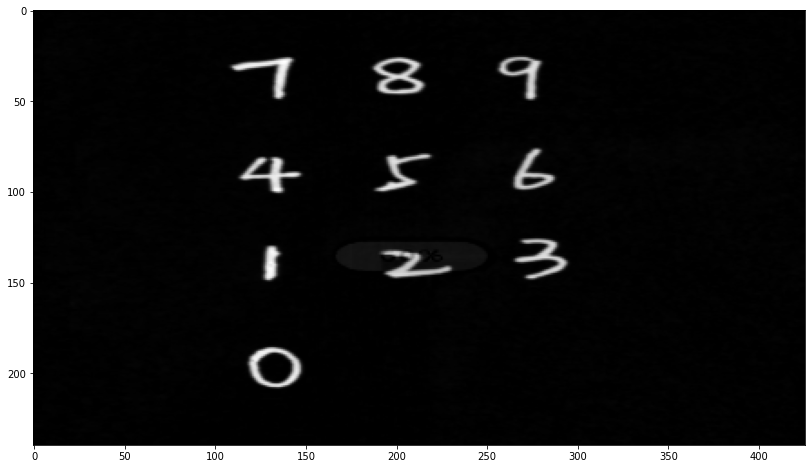

In [16]:
plt.figure(figsize=(15,8))
plt.imshow(img_reduct_background, cmap='gray')

In [67]:
img_pred = (np.reshape(img_seg[9],(-1,28,28,1))).astype('float32')

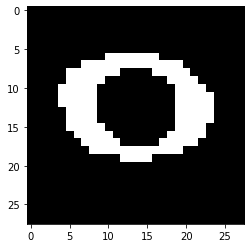

In [68]:
plt.imshow(img_seg[9], cmap='gray')

In [69]:
num = model.predict(img_pred)

In [70]:
num

array([[1.0000000e+00, 1.4601538e-19, 7.1526978e-18, 5.7834744e-23,
        3.0161059e-21, 1.4036499e-17, 5.9430227e-17, 5.3169506e-27,
        2.8434028e-16, 5.9180964e-23]], dtype=float32)

In [71]:
maximum = num[0][0]
idx = 0

for i in range(10):
    
    if (num[0][i] > maximum):
        
        maximum = num[0][i]
        
        idx = i
    
    
print('number is ', idx, ' :', maximum * 100, '%')

number is  0  : 100.0 %
